# Capstone Project 
### Applied Data Science Capstone by IBM/Coursera

## Introduction: Business Problem

The main objective of this project is to analyze London city, to understand/explore the best neighborhood to set up an Italian ice cream shop. This state-of-the-art shop targets the upper-level income population with a premium portfolio of innovative ice cream flavors. 
In this analysis, we are introducing boroughs public information: average individual income, tourists and population density. 
*See PDF for complete introduction* 

## Data <a name="data"></a>

*  Population per borough ("Population per square kilometer") 
*  Average income per borough. 
*  Hotels rooms per borough. 
*  Number of existing ice cream shops and frozen yoghurt shops in the neighborhoods of the selected borough, according to Foursquare.

In [3]:
import urllib.request, urllib.parse, urllib.error
import numpy as np 
import pandas as pd
from bs4 import BeautifulSoup
import wget
from pandas.io.json import json_normalize
import requests 

import numpy as np # library to handle data in a vectorized manner
import urllib.request, json 

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

print('Libraries imported.')

Libraries imported.


### Methodology 

First, we are going to describe each area and select some potential boroughs for our shop. Then, we are doing a K-Means clustering of London boroughs according to this information (population, income and tourists). Afterwards, we are using Foursquare data to understand in the selected borough which neighborhoods have the most quantity of ice cream shops, and indirect competition shops (like Frozen Yoghurt), to finally decide the winner location. The idea is to find an opportunity, good location but not so many competitors. *See PDF for complete Methodology* 

### London Borough Candidates - Results

#### Population

Let's analize London population density by Borough. We are using the variable "Population per square kilometre"

In [4]:
# create a table with Population information. The source of this files is: https://data.london.gov.uk/dataset/earnings-place-residence-borough
df_pop = pd.read_csv("housing-density-borough_v2.csv", delimiter=",")

In [5]:
# select only 2020 population figures. Change columns names to generate cohesion with other tables
df_pop = df_pop.loc[(df_pop.Year == 2020)]
df_pop.rename(columns={'Name':'Borough'}, inplace=True)
df_pop = df_pop[['Borough','Population_per_square_kilometre']]
df_pop.set_index('Borough', inplace=True) 
df_pop.head()

,Population_per_square_kilometre
Borough,
City of London,2770.7
Barking and Dagenham,6047.6
Barnet,4693.4
Bexley,4208.8
Brent,7953.6


In [6]:
# Main statistics of Population_per_square_kilometre
df_pop.describe().round(decimals=2)

,Population_per_square_kilometre
count,33.00
mean,7767.07
std,4181.09
min,2240.60
25%,4693.40
50%,6178.80
75%,11443.80
max,16583.50


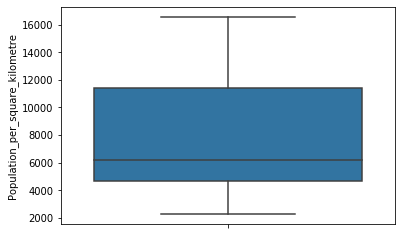

In [25]:
sns.boxplot(y="Population_per_square_kilometre", data=df_pop)

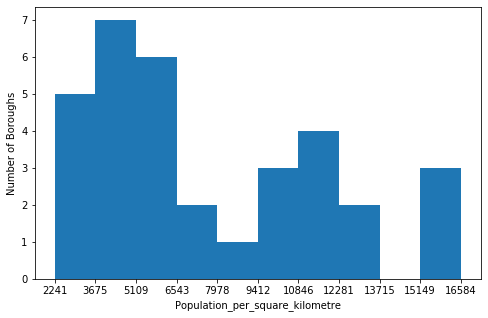

In [27]:
# 'bin_edges' is a list of bin intervals
count, bin_edges = np.histogram(df_pop['Population_per_square_kilometre'])

df_pop['Population_per_square_kilometre'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.ylabel('Number of Boroughs') # add y-label
plt.xlabel('Population_per_square_kilometre') # add x-label

plt.show()

We are going to select the boroughs that are part of the fourth quartile. These are the ones that are in the top 25% or have a population above 11445.8 per square km.

In [7]:
newdf_pop = df_pop.loc[(df_pop.Population_per_square_kilometre > 11443.8)]

In [8]:
newdf_pop.sort_values(['Population_per_square_kilometre'],ascending=False)

,Population_per_square_kilometre
Borough,
Tower Hamlets,16583.5
Islington,16344.7
Hackney,15197.0
Kensington and Chelsea,13262.4
Lambeth,12693.9
Westminster,12099.5
Camden,11812.4
Hammersmith and Fulham,11631.1


These are the most densely populated boroughs and that means a lot of potential clients. But how about income?

#### Income

In [9]:
# create a table with income information. The source of this files is: https://data.london.gov.uk/dataset/earnings-place-residence-borough
df_pay = pd.read_csv("earnings-residence-borough_v3.csv", delimiter=";")

In [10]:
# change columns names to generate cohesion with other tables
df_pay.rename(columns={'Area':'Borough'}, inplace=True)
df_pay = df_pay[['Borough','Pay']]
df_pay.set_index('Borough', inplace=True) 
df_pay.head()

,Pay
Borough,
City of London,"902,0"
Westminster,"766,6"
Wandsworth,"689,9"
Islington,"687,6"
Hammersmith and Fulham,"681,3"


In [11]:
# check and modify types to analyze quantitative variable income.
df_pay.dtypes

Pay    object
dtype: object

In [12]:
# check and modify types
df_pay['Pay'] = [x.replace(',', '.') for x in df_pay['Pay']]

In [13]:
# check and modify types
df_pay["Pay"] = pd.to_numeric(df_pay["Pay"])

In [14]:
# quick analysis of income 
df_pay.describe().round(decimals=2)

,Pay
count,33.00
mean,589.35
std,90.94
min,479.10
25%,535.90
50%,554.70
75%,632.50
max,902.00


Mean income for London boroughs is 589 pounds per week, with a minimum of 479 and a maximum of 902. This last figure for "City of London" is an outlier as we can see in the following Boxplot

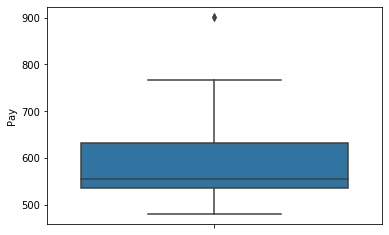

In [15]:
sns.boxplot(y="Pay", data=df_pay)

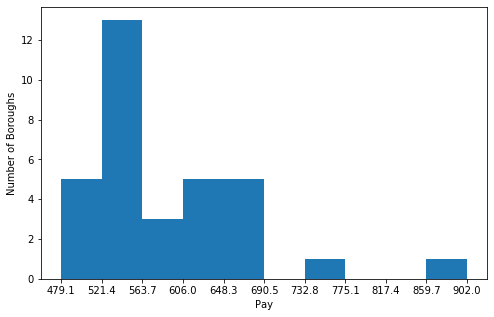

In [23]:
# 'bin_edges' is a list of bin intervals
count, bin_edges = np.histogram(df_pay['Pay'])

df_pay['Pay'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.ylabel('Number of Boroughs') # add y-label
plt.xlabel('Pay') # add x-label

plt.show()

We are going to select the boroughs that are part of the fourth quartile. These are the ones that are in the top 25% or have an income above 632.5

In [16]:
new_df_pay = df_pay.loc[(df_pay.Pay > 632.5)]

In [17]:
new_df_pay

,Pay
Borough,
City of London,902.0
Westminster,766.6
Wandsworth,689.9
Islington,687.6
Hammersmith and Fulham,681.3
Richmond upon Thames,678.2
Kensington and Chelsea,669.3
Camden,634.7


If  we plan to target our sales to high income boroughs we should definately take into consideration this ones.

#### Tourism

Now that we know which boroughs are the denser and wealthier let's revise which have more tourist. To do so we use public information of hotels rooms per borough. https://www.london.gov.uk/sites/default/files/visitor_accommodation_-_working_paper_88.pdf . The information has already been extracted from the PDF and saved in a csv file.

In [18]:
df_tourist = pd.read_csv("hotels_rooms_borough.csv", delimiter=";")

In [19]:
df_tourist.set_index('Borough', inplace=True) 
df_tourist.rename(columns={'Number of bedrooms':'Number_of_bedrooms'}, inplace=True)
df_tourist.head()

,Number_of_bedrooms
Borough,
Westminster,38480
Camden,18038
Kensington and Chelsea,15151
Hillingdon,9885
Tower Hamlets,6757


In [20]:
df_tourist.describe().round(decimals=2)

,Number_of_bedrooms
count,33.00
mean,4416.27
std,7365.71
min,235.00
25%,614.00
50%,1929.00
75%,4590.00
max,38480.00


In [21]:
df_tourist_new = df_tourist.loc[(df_tourist.Number_of_bedrooms > 4590)]
df_tourist_new

,Number_of_bedrooms
Borough,
Westminster,38480
Camden,18038
Kensington and Chelsea,15151
Hillingdon,9885
Tower Hamlets,6757
City of London,6064
Southwark,5802
Newham,4810


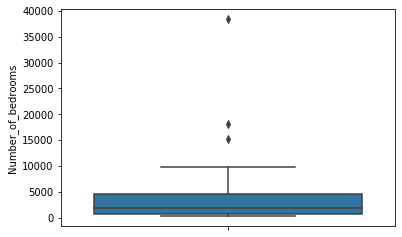

In [22]:
sns.boxplot(y="Number_of_bedrooms", data=df_tourist)

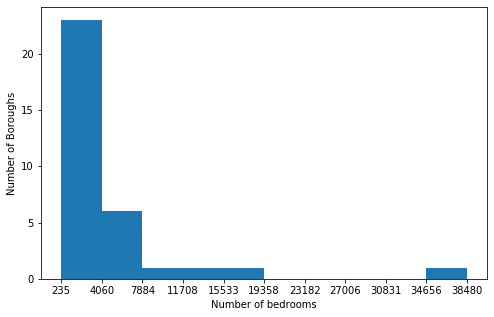

In [166]:
# 'bin_edges' is a list of bin intervals
count, bin_edges = np.histogram(df_tourist['Number_of_bedrooms'])

df_tourist['Number_of_bedrooms'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)

plt.ylabel('Number of Boroughs') # add y-label
plt.xlabel('Number of bedrooms') # add x-label

plt.show()

Accomodation is quite concentrated in a few boroughs: Westminster, Camden and Kensington and Chelsea 	

Join all the different tables.

In [25]:
df_merge = df_pop.merge(df_pay,on='Borough').merge(df_tourist,on='Borough')

In [26]:
df_merge.head()

,Population_per_square_kilometre,Pay,Number_of_bedrooms
Borough,,,
City of London,2770.7,902.0,6064
Barking and Dagenham,6047.6,479.1,562
Barnet,4693.4,536.6,1485
Bexley,4208.8,513.8,571
Brent,7953.6,480.0,2417


In [27]:
df_merge[(df_merge['Population_per_square_kilometre'] > 11443.8) & (df_merge['Pay'] > 632.5 ) & (df_merge['Number_of_bedrooms'] > 4590 )]

,Population_per_square_kilometre,Pay,Number_of_bedrooms
Borough,,,
Camden,11812.4,634.7,18038
Kensington and Chelsea,13262.4,669.3,15151
Westminster,12099.5,766.6,38480


Considering the three variables, these three boroughs are in the top 25% of each one. Good options for our shop.

### Cluster Analysis

The objective of this analysis is to understand which boroughs are alike in terms of population density, income and tourism.

In [28]:
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler

In [29]:
df_merge.reset_index(inplace=True)

Normalize the dataset.

In [30]:
london_clustering = df_merge.drop('Borough', 1)
X = london_clustering.values
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

array([[-1.21351810e+00,  3.49108412e+00,  2.27170991e-01],
       [-4.17624258e-01, -1.23108645e+00, -5.31385848e-01],
       [-7.46532506e-01, -5.89032047e-01, -4.04132493e-01],
       [-8.64232209e-01, -8.43620577e-01, -5.30145025e-01],
       [ 4.53052370e-02, -1.22103691e+00, -2.75638313e-01],
       [-1.34226885e+00,  4.81803040e-01, -5.31110110e-01],
       [ 9.82531016e-01,  5.06368600e-01,  1.87801788e+00],
       [-7.62611170e-01, -4.17073128e-01, -2.53992835e-01],
       [-3.04272109e-01, -7.40891872e-01, -2.95215753e-01],
       [-8.55852845e-01, -1.23108645e+00, -4.99813781e-01],
       [-3.85758387e-01, -1.74767378e-01, -3.26512082e-01],
       [ 1.80458304e+00, -3.76874939e-01, -3.42918528e-01],
       [ 9.38496851e-01,  1.02671182e+00,  2.39516559e-02],
       [ 4.84311041e-01, -4.60621166e-01, -5.63509393e-01],
       [-6.28589923e-01, -5.70049569e-01, -5.09878239e-01],
       [-1.32043392e+00, -5.04169204e-01, -5.29455678e-01],
       [-1.22257753e+00, -6.41513016e-01

### Modeling

In [178]:
num_clusters = 5

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[2 1 0 0 1 0 4 0 1 0 0 4 4 1 0 0 0 0 4 4 0 4 1 0 1 0 0 4 0 4 1 4 3]


We assign the labels to each row in dataframe.

In [185]:
df_merge["Labels"] = labels

We can check the centroid values by averaging the features in each cluster.

In [186]:
df_merge.groupby('Labels').mean().round(decimals=2)

,Population_per_square_kilometre,Pay,Number_of_bedrooms
Labels,,,
0,4395.89,562.27,1878.40
1,8117.87,512.84,1636.43
2,2770.70,902.00,6064.00
3,12099.50,766.60,38480.00
4,13186.62,639.57,6840.22


In [187]:
# Analyze some interesting Clusters:
df_merge.sort_values(by=['Labels']).loc[(df_merge.Labels == 3)]

,Borough,Population_per_square_kilometre,Pay,Number_of_bedrooms,Labels
32,Westminster,12099.5,766.6,38480,3


Westminster is the only borough in this cluster, with high income, huge population density and plenty of hotels rooms. It is a good option for our shop. The competition will be intense, but in the correct neighbourhood, we could succeed!

In [188]:
# Analyze some interesting Clusters:
df_merge.sort_values(by=['Labels']).loc[(df_merge.Labels == 2)]

,Borough,Population_per_square_kilometre,Pay,Number_of_bedrooms,Labels
0,City of London,2770.7,902.0,6064,2


This cluster has some relation with the last one in terms of income, but the City hasn't got so many hotels rooms and people living there. 

In [189]:
# Analyze some interesting Clusters:
df_merge.sort_values(by=['Labels']).loc[(df_merge.Labels == 4)]

,Borough,Population_per_square_kilometre,Pay,Number_of_bedrooms,Labels
19,Kensington and Chelsea,13262.4,669.3,15151,4
18,Islington,16344.7,687.6,3633,4
31,Wandsworth,9710.8,689.9,1393,4
12,Hammersmith and Fulham,11631.1,681.3,4590,4
27,Southwark,11443.8,589.4,5802,4
11,Hackney,15197.0,555.6,1929,4
29,Tower Hamlets,16583.5,627.9,6757,4
6,Camden,11812.4,634.7,18038,4
21,Lambeth,12693.9,620.4,4269,4


Cluster 4 is also a valid option. There are some very touristic boroughs with a large number of wealthy residents.

The other two clusters are not good options for our shop. They might be considered for a niche alternative.

**Please take into consideration that cluster numbers might change once you run the analysis.*

### The first winner: Westminster

We chose this borough to put our shop, but where? The borough is quite extended and has many districts. According to Wikipedia (https://en.wikipedia.org/wiki/List_of_districts_in_the_City_of_Westminster) there are more than 30 different districts. Let's analyze where they are located.

In [34]:
address = 'City of Westminster, London'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Westminster are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Westminster are 51.4973206, -0.137149.


In [38]:
df_west = pd.read_csv("westminster.csv", delimiter=";")

In [41]:
df_west.head()

,Neighborhood,Latitude,Longitude
0,Adelphi,51.509167,-0.12250
1,Aldwych,51.513200,-0.11670
2,Bayswater,51.509500,-0.19290
3,Belgravia,51.497950,-0.15453
4,Charing Cross,51.507300,-0.12755


In [39]:
# create map of Westminster using latitude and longitude values
map_west = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough in zip(df_west['Latitude'], df_west['Longitude'], df_west['Neighborhood']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_west)  
    
map_west

### Foursquare - Westminster Ice Cream Shops
We have our location candidates, let's use Foursquare API to get info on ice-cream shops in each neighborhood

In [92]:
CLIENT_ID = '5VJ44BEITBESYOZPPQVOENNO4QW2T22FCLL5OOWDHGK2RG0Z' # your Foursquare ID
CLIENT_SECRET = 'CSBGMT3XQ3GN0OJIPYXYTKBLX2NAP42OWFTMZM1BIO4ZLCCB' # your Foursquare Secret
VERSION = '20180323' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5VJ44BEITBESYOZPPQVOENNO4QW2T22FCLL5OOWDHGK2RG0Z
CLIENT_SECRET:CSBGMT3XQ3GN0OJIPYXYTKBLX2NAP42OWFTMZM1BIO4ZLCCB


Now lets search for ice cream shops in this neighborhoods

In [205]:
categoryId = '4bf58dd8d48988d1c9941735' # this is the classification code for this type of shops (https://developer.foursquare.com/docs/build-with-foursquare/categories/)

In [206]:
def getNearbyHelado(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng,
            VERSION, 
            categoryId,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues)

In [207]:
westminster_ice = getNearbyHelado(names=df_west['Neighborhood'],
                                   latitudes=df_west['Latitude'],
                                   longitudes=df_west['Longitude']
                                  )

Adelphi
Aldwych
Bayswater
Belgravia
Charing Cross
Chinatown
Covent Garden
Fitzrovia
Kensal Town
Hyde Park
Knightsbridge
Lisson Grove
Maida Vale
Marylebone
Mayfair
Millbank
Paddington
Paddington Green
Pimlico
Portman Estate
Queen's Park
Soho
St James's
St John's Wood
Strand
Temple
Victoria
Westbourne
Westbourne Green
Westminster


In [208]:
print(westminster_ice.shape)
westminster_ice.head()

(157, 6)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
0,Adelphi,51.509167,-0.1225,Milk Train,51.511577,-0.121568
1,Adelphi,51.509167,-0.1225,Venchi,51.511888,-0.122484
2,Adelphi,51.509167,-0.1225,Amorino,51.511510,-0.125794
3,Adelphi,51.509167,-0.1225,Gelatorino,51.512737,-0.120977
4,Adelphi,51.509167,-0.1225,La Gelatiera,51.511046,-0.126828


Some neighborhoods are very close, so there might be some ice cream shops that appear duplicated in the list.

In [209]:
top_ice = westminster_ice['Neighborhood'].value_counts().rename_axis('unique_values').to_frame('counts')
top_ice

,counts
unique_values,
Chinatown,26
Soho,25
St James's,18
Covent Garden,14
Adelphi,9
Strand,8
Bayswater,8
Aldwych,7
Westbourne,6


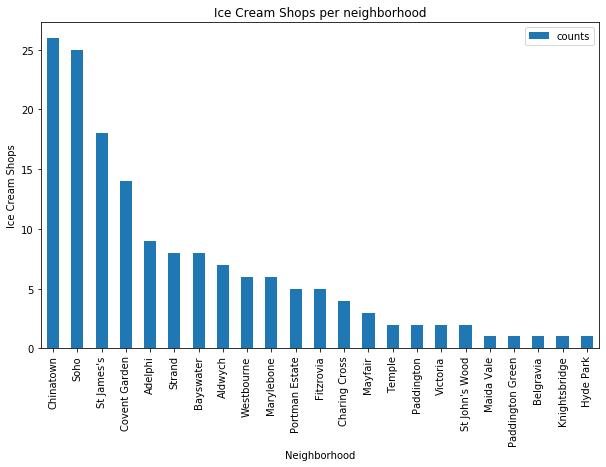

In [215]:
# step 2: plot data
top_ice.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Ice Cream Shops') # add y-label to the plot
plt.title('Ice Cream Shops per neighborhood') # add title to the plot

plt.show()

Let's see them in a map.

In [211]:
# create map of Westminster using latitude and longitude values
map_west = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to Shops
for lat, lng, borough in zip(westminster_ice['Venue Latitude'], westminster_ice['Venue Longitude'], westminster_ice['Venue']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#E94975',
        fill_opacity=0.7,
        parse_html=False).add_to(map_west)  
    
# add markers to Neighborhoods
for lat, lng, borough in zip(df_west['Latitude'], df_west['Longitude'], df_west['Neighborhood']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_west)  
    
map_west

In [137]:
westminster_ice.shape

(157, 6)

As we can see this type of shops tend to be concentrated around some zones as Soho, Chinatown, St.James and Covent Garden. However, according to Foursquare information, some other zones do not have an ice cream shop nearby like Pimlico, Millbank or Queen's Park. Do they have Frozen Yoghurt at least? It seems they don't

Lets search for frozen yoghurt shops in this neighborhoods

In [198]:
categoryId = '512e7cae91d4cbb4e5efe0af' # this is the classification code for this type of shops (https://developer.foursquare.com/docs/build-with-foursquare/categories/)

In [199]:
westminster_yog = getNearbyHelado(names=df_west['Neighborhood'],
                                   latitudes=df_west['Latitude'],
                                   longitudes=df_west['Longitude']
                                  )

Adelphi
Aldwych
Bayswater
Belgravia
Charing Cross
Chinatown
Covent Garden
Fitzrovia
Kensal Town
Hyde Park
Knightsbridge
Lisson Grove
Maida Vale
Marylebone
Mayfair
Millbank
Paddington
Paddington Green
Pimlico
Portman Estate
Queen's Park
Soho
St James's
St John's Wood
Strand
Temple
Victoria
Westbourne
Westbourne Green
Westminster


In [200]:
top_yog = westminster_yog['Neighborhood'].value_counts().rename_axis('unique_values').to_frame('counts')
top_yog

,counts
unique_values,
St James's,2
Chinatown,2
Adelphi,2
Soho,2
Westbourne,1
Covent Garden,1
Charing Cross,1


It seems that frozen yoghurt is not as popular as ice cream or it is not well served in the area.

### Conclusion

*  Westminster might be a suitable option, since it has an extensive wealthy population and a high quantity of tourists.
*  Other boroughs in Cluster 4 like Kensington & Chelsea and Camden are good alternatives too. 
*  Specific areas that haven’t got many ice cream shops in Westminster and might be suitable options are: Millbank, Pimlico, Queens Park, Lisson Grove, Kensal Town and Westbourne Greene.
